## **Imports**

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

## **Data**

In [2]:
def df_to_csr(df, n_users, n_items):
    row = df['user_id']
    col = df['item_id']
    data = df['rating']
    return csr_matrix((data, (row, col)), shape=(n_users, n_items))

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

item_info = pd.read_csv('movies.dat', sep='::', names=['item_id', 'title', 'genres'] , encoding='latin-1')
num_for_item_id = {item_id: i for i, item_id in enumerate(np.unique(item_info['item_id']))}
item_info['item_id'] = item_info['item_id'].map(num_for_item_id)
item_info['genres'] = item_info['genres'].apply(lambda g: g.split('|'))

mlb = MultiLabelBinarizer()
item_genres = pd.DataFrame(mlb.fit_transform(item_info['genres'])).set_index(item_info['item_id'])

In [4]:
all_data = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'item_id', 'rating', 'datetime'], encoding='latin-1')

num_for_user_id = {user_id: i for i, user_id in enumerate(np.unique(all_data['user_id']))}
all_data['user_id'] = all_data['user_id'].map(num_for_user_id)
all_data['item_id'] = all_data['item_id'].map(num_for_item_id)

In [5]:
n_users = len(num_for_user_id)
n_items = len(num_for_item_id)
n_ratings = len(all_data)

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all_data,
                               stratify=all_data['user_id'],
                               test_size=0.1,
                               random_state=42)

train_data_csr = df_to_csr(train_data, n_users, n_items)
test_data_csr = df_to_csr(test_data, n_users, n_items)

## **MostPopular, Trending, PrevioslyViewed**

### ***Based class for MostPopular, Trending, PrevioslyViewed***

In [7]:
class Based:
    def predict_subset(self, user_subset):
        len_subset = len(user_subset)
        predict = np.repeat([self.item_rating], len_subset, axis=0)
        return predict

    def predict_df(self, df):
        df['rating'] = self.item_rating[df['item_id']]
        return df

    def recommend_subset(self, user_subset, k, viewed=pd.DataFrame(columns=['user_id', 'item_id'])):
        map = {user: i for i, user in enumerate(user_subset)}
        viewed['user_id'] = viewed['user_id'].map(map)
        viewed = viewed.dropna().astype(int)
        
        pred = self.predict_subset(user_subset)
        pred[np.array(viewed['user_id']), np.array(viewed['item_id'])] = 0
        unsorted_top_k = np.argpartition(-pred, k)[:,:k]
        pred = np.take_along_axis(pred, unsorted_top_k, axis=1)
        return np.take_along_axis(unsorted_top_k, np.argsort(-pred, axis=1), axis=1)
      
    def recommend_df(self, df, k):
        predicted = self.predict_df(df).sort_values(by='rating', axis=0, ascending=False)
        recommend = predicted.groupby('user_id').head(k)
        recommend['rank'] = recommend.groupby('user_id').cumcount() + 1
        return recommend.reset_index(drop=True)

### ***Most Popular***

In [8]:
class MostPopular(Based):
    def __init__(self):
        self.item_rating = None
        self.n_items = None

    def fit(self, dataset, n_items):
        self.n_items = n_items
        missing = np.array(list(set(np.arange(self.n_items)) - set(dataset['item_id'])), dtype=int)
        dataset = dataset.append(pd.DataFrame({'item_id': missing}))

        self.item_rating = np.array(dataset.groupby('item_id')['item_id'].count())
        self.item_rating[missing] = 0

        return self

### ***Trending***

In [9]:
class Trending(Based):
    def __init__(self):
        self.item_rating = None
        self.n_items = None
        self.coef = None
        self.start_time = None

    def fit(self, dataset, n_items):
        self.n_items = n_items
        self.start_time = min(dataset['datetime'])
        self.coef = 1 / (max(dataset['datetime']) - self.start_time)
        dataset['weight'] = np.exp(-self.coef * (dataset['datetime'] - self.start_time))
        
        missing = np.array(list(set(np.arange(self.n_items)) - set(dataset['item_id'])), dtype=int)
        dataset = dataset.append(pd.DataFrame({'item_id': missing}))
        agg_dataset = dataset.groupby('item_id').agg({'weight': ['sum']})

        self.item_rating = np.array(agg_dataset['weight', 'sum'])
        self.item_rating[missing] = 0

        return self

### ***PreviouslyViewed***

In [10]:
class PreviouslyViewed(Based):
    def __init__(self):
        self.item_rating = None
        self.n_users = None
        self.n_items = None

    def _df_to_array(self, df):
        grouped = df.groupby('user_id')['item_id'].apply(np.array).values
        return np.reshape(np.concatenate(grouped), (len(grouped),-1))

    def fit(self, dataset, n_items, n_users):
        self.n_users = n_users
        self.n_items = n_items
        missing = np.array(list(set(np.arange(self.n_users)) - set(dataset['user_id'])), dtype=int)
        dataset = dataset.append(pd.DataFrame({'user_id': missing}))

        dataset.sort_values(by='datetime', ascending=False)
        agg_dataset = dataset.groupby('user_id')['item_id'].apply(np.array)
        self.item_rating = agg_dataset.to_list()

        return self

    def predict_subset(self, user_subset):
        data = np.empty((0, 3))
        for user in user_subset:
            n_user_items = len(self.item_rating[user])
            repeated_user = np.repeat(user, n_user_items)
            items = self.item_rating[user]
            rating = np.arange(1, n_user_items + 1)
            data = np.concatenate((data, np.column_stack((repeated_user, items, rating))), axis=0)

        return pd.DataFrame(data.astype(int), columns=['user_id', 'item_id', 'rating'])

    def predict_df(self, df):
        rating = []
        for i, [user_id, item_id] in df.iterrows():
            ind_item = np.where(self.item_rating[user_id] == item_id)[0]
            rating.append(ind_item[0] + 1 if len(ind_item) > 0 else 0)
        df['rating'] = rating 

        return df

    def recommend_subset(self, user_subset, k, viewed=pd.DataFrame(columns=['user_id', 'item_id'])):
        map = {user: i for i, user in enumerate(user_subset)}
        viewed['user_id'] = viewed['user_id'].map(map)
        viewed = viewed.dropna().astype(int)
        
        predicted = self.predict_subset(user_subset)        
        predicted = predicted.drop(np.where(predicted['user_id'].isin(viewed['user_id']) & predicted['item_id'].isin(viewed['item_id']))[0])
        recommend = predicted.groupby('user_id').head(k)
        recommend['rank'] = recommend.groupby('user_id').cumcount() + 1

        return self._df_to_array(recommend.reset_index(drop=True))

    def recommend_df(self, df, k):
        predicted = self.predict_df(df).sort_values(by='rating', axis=0)
        recommend = predicted.groupby('user_id').head(k)
        recommend['rank'] = recommend.groupby('user_id').cumcount() + 1
        return recommend.reset_index(drop=True)

### *Comparison of working time*

In [11]:
def with_apply_along_axis(data, k=10):
    return np.apply_along_axis(lambda row: np.argsort(row)[::-1][:k], axis=1, arr=data)

def with_argsort(data, k=10):
    return np.argsort(data, axis=1)[:,::-1][:,:k]

def with_argpartition(data, k=10):
    unsorted = np.argpartition(-data, k)[:,:k]
    data = np.take_along_axis(data, unsorted, axis=1)
    return np.take_along_axis(unsorted, np.argsort(-data, axis=1), axis=1)

def with_torch_sort(data, k=10):
    data = torch.from_numpy(data)
    return torch.sort(data, descending=True).indices[:,:k]

def with_torch_argsort(data, k=10):
    data = torch.from_numpy(data)
    return torch.argsort(data, dim=1, descending=True)[:,:k]

def with_torch_topk(data, k=10):
    data = torch.from_numpy(data)    
    return torch.topk(data, k).indices[:,:k]

In [12]:
model = MostPopular()
model.fit(train_data, n_items)
preds = model.predict_subset(np.arange(n_users))

%timeit with_apply_along_axis(preds)
%timeit with_argsort(preds)
%timeit with_argpartition(preds)

%timeit with_torch_sort(preds)
%timeit with_torch_argsort(preds)
%timeit with_torch_topk(preds)

1.43 s ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.36 s ± 8.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
125 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.51 s ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.51 s ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
56.5 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## **UserBased, ItemBased, SVD, ContentBased**

### ***Based class for UserBased, ItemBased, SVD***

In [13]:
class Based:
    def __init__(self, min_n_user_rating=700):
        self.min_n_user_rating = min_n_user_rating
      
    def recommend(self, data, k, recs_to_remove=None):
        preds = self.predict(data)

        if recs_to_remove is not None:
            recs_to_remove = np.array(recs_to_remove)
            preds[recs_to_remove[:,0], recs_to_remove[:,1]] = 0

        top_k = np.array(np.argpartition(-preds, k)[:,:k])
        preds = np.take_along_axis(preds, top_k, axis=1)
        top_k = np.take_along_axis(top_k, np.argsort(-preds, axis=1), axis=1)
        return top_k

In [14]:
def row_mean(data):
    sums = data.sum(axis=1).A1
    counts = np.diff(data.indptr)
    means = sums / counts
    return means[np.newaxis].T

def norm_rating(data):
    counts = np.diff(data.indptr)
    means = row_mean(data)
    mc = np.repeat(means, counts)
    
    data_copy = data.copy()
    data_copy.data = data_copy.data.astype(np.float64)
    data_copy.data -= mc
    return data_copy

def vector_norm(data):
    return np.sqrt(np.sum(data.power(2), axis=1))

### ***User Based***

In [15]:
pip install nmslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 3.7 MB/s 
     |████████████████████████████████| 188 kB 67.9 MB/s 


In [16]:
import nmslib

Use Hierarchical Navigable Small World (HNSW) for approximate nearest neighbor search. [Habr](https://habr.com/ru/company/vk/blog/338360/)

In [17]:
class UserBased_HNSW(Based):
    def fit(self, data):
        self.data = norm_rating(data[data.getnnz(axis=1) >= self.min_n_user_rating])
        self.norms = vector_norm(self.data)

        self.index = nmslib.init(space='cosinesimil_sparse', method='hnsw', data_type=nmslib.DataType.SPARSE_VECTOR)
        self.index.addDataPointBatch(self.data)
        self.index.createIndex({}, print_progress=True)
        return self

    def predict(self, data):
        neighbours, similarity = zip(*self.index.knnQueryBatch(data, k=10, num_threads=4))
        neigh_data = np.take(self.data.toarray(), np.array(neighbours), axis=0)
        similarity = np.array(similarity).reshape((neigh_data.shape[0], 1, -1))
        rating = np.matmul(similarity, neigh_data).reshape(data.shape) + row_mean(data)
        rating = np.nan_to_num(rating)
        
        assert rating.shape == data.shape
        return rating

In [18]:
class UserBased(Based):
    def fit(self, data):
        self.data = norm_rating(data[data.getnnz(axis=1) >= self.min_n_user_rating])
        self.norms = vector_norm(self.data)
        
        return self

    def predict(self, data):
        new_data = norm_rating(data)
        new_norms = vector_norm(new_data)

        scalar_dots = new_data.dot(self.data.T)
        similarity = csr_matrix(scalar_dots / new_norms.dot(self.norms.T))
        rating = np.array(similarity.dot(self.data).A / np.sum(similarity, axis=1)) + row_mean(data)
        rating = np.nan_to_num(rating)
        
        assert rating.shape == data.shape
        return rating

In [19]:
print('With HNSW:')
user_based = UserBased_HNSW()
%timeit user_based.fit(train_data_csr)
%timeit user_based.predict(train_data_csr)

print('Without:')
user_based2 = UserBased()
%timeit user_based2.fit(train_data_csr)
%timeit user_based2.predict(train_data_csr)

With HNSW:
241 ms ± 74.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.45 s ± 1.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without:
6.94 ms ± 89.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.14 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ***Item Based***

In [20]:
class ItemBased(Based):
    def fit(self, data):
        scalar_dots = data.T.dot(data)
        norms = np.matrix(np.sqrt(scalar_dots.diagonal()))
        self.similarity = csr_matrix(scalar_dots / norms.T.dot(norms) - np.eye(data.shape[1]))
        self.similarity.data = np.nan_to_num(self.similarity.data)
        return self

    def predict(self, data):
        rating = data.dot(self.similarity).A / np.sum(self.similarity.A, axis=0)
        rating = np.nan_to_num(rating)
        assert rating.shape == data.shape
        return rating

### ***SVD***

In [21]:
from sklearn.decomposition import TruncatedSVD

class SVD(Based):
    def __init__(self, min_n_user_rating=700, n_factors=8):
        super().__init__(min_n_user_rating)
        self.n_factors = n_factors

    def fit(self, data):
        data = data[data.getnnz(axis=1) >= self.min_n_user_rating]
        self.svd = TruncatedSVD(self.n_factors)
        self.svd.fit(data)
        return self

    def predict(self, data):
        U = self.svd.transform(data)
        similarity = U.dot(self.svd.components_)

        assert similarity.shape == data.shape
        return similarity

### ***ContentBased***

In [22]:
class ContentBased(Based):
    def fit(self, item_info):
        scalar_dots = item_info.dot(item_info.T)
        norms = np.sqrt(scalar_dots.diagonal())[np.newaxis]
        self.similarity = csr_matrix(scalar_dots / norms.T.dot(norms) - np.eye(item_info.shape[0]))
        self.similarity.data = np.nan_to_num(self.similarity.data)
        return self
      
    def predict(self, data):
        rating = data.dot(self.similarity).A / np.sum(self.similarity.A, axis=0)
        rating = np.nan_to_num(rating)
        assert rating.shape == data.shape
        return rating

## **Autoencoder, VAE**

In [23]:
def BCE(recon_x, x):
    loss = nn.BCELoss()
    return loss(recon_x, x)

def MSE_masked(recon_x, x):
    mask = x > 0
    sq_err = torch.pow(x - recon_x, 2).mul(mask)
    return torch.mean(torch.sum(sq_err, dim=1) / torch.count_nonzero(mask, dim=1))

def MSE(recon_x, x):
    loss = nn.MSELoss()
    return loss(recon_x, x)

In [24]:
class Autoencoder(nn.Module):
    def __init__(self, p_dims, activation_fn, act_fn_last_layer=None):
        super(Autoencoder, self).__init__()
        self.activation_fn = activation_fn
        self.act_fn_last_layer = act_fn_last_layer

        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(self.q_dims[:-1], self.q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

    def forward(self, input):
        h = self.encode(input)
        return self.decode(h)

    def encode(self, input):
        h = nn.functional.normalize(input)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            act_fn = self.activation_fn()
            h = act_fn(h)
        return h

    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                act_fn = self.activation_fn()
                h = act_fn(h)
            elif self.act_fn_last_layer is not None:
                act_fn = self.act_fn_last_layer()
                h = act_fn(h)
        return h

In [25]:
class TrainAutoencoder():
    def __init__(self, min_n_user_rating=700, n_epoch=40, activation_fn=nn.Sigmoid, act_fn_last_layer=None, loss_fn=MSE, batch_size=10):
        self.min_n_user_rating = min_n_user_rating
        self.n_epoch = n_epoch
        self.activation_fn = activation_fn
        self.batch_size = batch_size

        self.model = Autoencoder([10, 20, n_items], self.activation_fn, act_fn_last_layer)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-3)
        self.criterion = loss_fn

    def fit(self, data):
        input = data[data.getnnz(axis=1) >= self.min_n_user_rating]
        if not (self.criterion == MSE or self.criterion == MSE_masked):
            input.data = np.array([input.data > 0])
        input = torch.FloatTensor(input.toarray())

        for epoch in range(self.n_epoch):
            for batch_idx, start_idx in enumerate(range(0, input.shape[0], self.batch_size)):
                end_idx = min(start_idx + self.batch_size, input.shape[0])
                batch = input[start_idx:end_idx]

                self.optimizer.zero_grad()
                output = self.model(batch)
                loss = self.criterion(output, batch)
                loss.backward()
                self.optimizer.step()

        return self

    def predict(self, data):
        input = data.copy()
        if not (self.criterion == MSE or self.criterion == MSE_masked):
            input.data = np.array([input.data > 0])
        input = torch.FloatTensor(data.toarray())

        self.model.eval()
        with torch.no_grad():
            rating = self.model(input)
        assert rating.shape == data.shape
        return rating

    def recommend(self, data, k):
        preds = self.predict(data)
        return np.array(torch.topk(preds, k).indices[:,:k])

In [26]:
class VAE(nn.Module):
    def __init__(self, p_dims, activation_fn, act_fn_last_layer=None):
        super(VAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]
        self.activation_fn = activation_fn
        self.act_fn_last_layer = act_fn_last_layer

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = nn.functional.normalize(input)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                act_fn = self.activation_fn()
                h = act_fn(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                act_fn = self.activation_fn()
                h = act_fn(h)
            elif self.act_fn_last_layer is not None:
                act_fn = self.act_fn_last_layer()
                h = act_fn(h)
        return h

In [27]:
class TrainVAE():
    def __init__(self, min_n_user_rating=700, n_epoch=40, activation_fn=nn.Sigmoid, act_fn_last_layer=None, loss_fn=MSE, batch_size=10):
        self.min_n_user_rating = min_n_user_rating
        self.n_epoch = n_epoch
        self.activation_fn = activation_fn
        self.batch_size = batch_size

        self.model = VAE([10, 20, n_items], self.activation_fn, act_fn_last_layer)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-3)
        self.criterion = loss_fn
        
    def fit(self, data):
        input = data[data.getnnz(axis=1) >= self.min_n_user_rating]
        if not (self.criterion == MSE or self.criterion == MSE_masked):
            input.data = np.array([input.data > 0])
        input = torch.FloatTensor(input.toarray())
        
        self.model.train()
        for epoch in range(self.n_epoch):
            for batch_idx, start_idx in enumerate(range(0, input.shape[0], self.batch_size)):
                end_idx = min(start_idx + self.batch_size, input.shape[0])
                batch = input[start_idx:end_idx]

                self.optimizer.zero_grad()
                output, mu, logvar = self.model(batch)
                loss = self.criterion(output, batch)
                loss.backward()
                self.optimizer.step()      

        return self

    def predict(self, data):
        input = data.copy()
        if not (self.criterion == MSE or self.criterion == MSE_masked):
            input.data = np.array([input.data > 0])
        input = torch.FloatTensor(input.toarray())

        self.model.eval()
        rating, mu, logvar = self.model(input)
        rating.shape == data.shape
        return rating

    def recommend(self, data, k):
        preds = self.predict(data)
        return np.array(torch.topk(preds, k).indices[:,:k])

## **DSSM**

In [28]:
class DSSM(nn.Module):
    def __init__(self, item_dims, user_dims, act_fn=nn.Sigmoid):
        super(DSSM, self).__init__()
        self.item_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(item_dims[:-1], item_dims[1:])])
        self.user_layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out in zip(user_dims[:-1], user_dims[1:])])
        self.act_fn = act_fn()

    def forward(self, items, users):
        for i, layer in enumerate(self.item_layers):
            items = layer(items)
            items = self.act_fn(items)

        for i, layer in enumerate(self.user_layers):
            users = layer(users)
            users = self.act_fn(users)

        cos = nn.CosineSimilarity(dim=2)
        users = users.unsqueeze(1).repeat(1, items.shape[0], 1)
        items = items.unsqueeze(0).repeat(users.shape[0], 1, 1)
        similarity = cos(items, users)

        return similarity

In [29]:
class TrainDSSM():
    def __init__(self, min_n_user_rating=700, n_epoch=10, act_fn=nn.Sigmoid, loss_fn=BCE, batch_size=10):
        self.min_n_user_rating = min_n_user_rating
        self.n_epoch = n_epoch
        self.act_fn = act_fn
        self.criterion = loss_fn
        self.batch_size = batch_size
        
    def fit(self, data):
        input = data[data.getnnz(axis=1) >= self.min_n_user_rating]
        input.data = np.array([input.data > 0])
        input = torch.FloatTensor(input.toarray())
        self.items = torch.transpose(input, 0, 1)
        
        self.model = DSSM(item_dims=[input.shape[0], 300, 128], user_dims=[input.shape[1], 300, 128], act_fn=self.act_fn)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-3)
        
        self.model.train()
        for epoch in range(self.n_epoch):
            for start_idx in range(0, input.shape[0], self.batch_size):
                end_idx = min(start_idx + self.batch_size, input.shape[0])
                user_batch = input[start_idx:end_idx]
                item_batch = self.items

                self.optimizer.zero_grad()
                similarity = self.model(item_batch, user_batch)
                loss = self.criterion(similarity, user_batch)
                loss.backward()
                self.optimizer.step()

        return self

    def predict(self, data):
        input = data.copy()
        input = torch.FloatTensor(input.toarray())

        self.model.eval()
        similarity = self.model(self.items, input)

        return similarity

    def recommend(self, data, k):
        batches = []

        for start_idx in range(0, data.shape[0], self.batch_size):
            end_idx = min(start_idx + self.batch_size, data.shape[0])
            user_batch = data[start_idx:end_idx]
            preds = self.predict(user_batch)
            recs_batch = np.array(torch.topk(preds, k).indices[:,:k])
            batches.append(recs_batch)
        
        recs = np.concatenate(batches, axis=0)
        return recs

## **Score**

### ***Score functions***

In [30]:
def recall(matrix_test, matrix_rec, k):
    all_relevant = np.diff(matrix_test.indptr)
    nonzero_ind = np.array(np.split(matrix_test.indices, matrix_test.indptr[1:-1]))
    relevant_rec = np.array(list(map(lambda a, b: len(np.intersect1d(a, b)), nonzero_ind, matrix_rec[:,:k])))

    recall = relevant_rec / all_relevant
    
    return np.nanmean(recall)

In [31]:
def precision(matrix_test, matrix_rec, k):
    batch_users = matrix_rec.shape[0]
    topk_rec = matrix_rec[:,:k]
    
    relevant_rec = np.sum(matrix_test[np.arange(batch_users)[:, np.newaxis], topk_rec].toarray(), axis=1)
    precision = relevant_rec / k
    
    return np.mean(precision)

In [32]:
def MAP(matrix_test, matrix_rec, k):
    batch_users = matrix_rec.shape[0]
    topk_rec = matrix_rec[:,:k]

    relevant_by_col = matrix_test[np.arange(batch_users)[:, np.newaxis], topk_rec].toarray()
    relevant_rec = np.cumsum(relevant_by_col, axis=1) * relevant_by_col
    precision = np.sum(relevant_rec / np.arange(1, k + 1), axis=1) / k

    return np.mean(precision)

In [33]:
def nDCG(matrix_test, matrix_rec, k):
    batch_users = matrix_rec.shape[0]
    topk_rec = matrix_rec[:,:k]
    
    tp = 1. / np.log2(np.arange(2, k + 2))
    DCG = (matrix_test[np.arange(batch_users)[:, np.newaxis], topk_rec].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum() for n in matrix_test.getnnz(axis=1)])

    return np.mean(DCG / IDCG)

In [34]:
def Diversity(matrix_rec, k, genres):
    used_genre = np.zeros((len(matrix_rec), genres.shape[1]), dtype=int)
    for i in range(k):
        cur_genre = genres.loc[matrix_rec[:,i]].to_numpy()
        used_genre = np.logical_or(used_genre, cur_genre)
    diversity = np.sum(used_genre, axis=1)

    return np.nanmean(diversity) / genres.shape[1]

In [35]:
def Scores(test, rec, k):
    return recall(test, rec, k), precision(test, rec, k), MAP(test, rec, k), nDCG(test, rec, k), Diversity(rec, k, item_genres)

Test score functions

In [36]:
indptr = [0, 3]
indices = [0, 3, 4]
data = [1, 1, 1]
test = csr_matrix((data, indices, indptr), shape=(1, 5))
rec = np.array([[0, 1, 3]])

assert np.isclose(recall(test, rec, 1), 1/3)
assert np.isclose(recall(test, rec, 2), 1/3)
assert np.isclose(recall(test, rec, 3), 2/3)

assert np.isclose(precision(test, rec, 1), 1)
assert np.isclose(precision(test, rec, 2), 1/2)
assert np.isclose(precision(test, rec, 3), 2/3)

assert np.isclose(MAP(test, rec, 1), 1)
assert np.isclose(MAP(test, rec, 2), 1/2)
assert np.isclose(MAP(test, rec, 3), 5/9)

assert np.isclose(nDCG(test, rec, 1), 1)
assert np.isclose(nDCG(test, rec, 2), 1 / (1 + 1/np.log2(3)))
assert np.isclose(nDCG(test, rec, 3), 1.5 / (1.5 + 1/np.log2(3)))

### ***Comparison of scores***

In [37]:
most_pop = MostPopular()
trend = Trending()
user_based_hnsw = UserBased_HNSW()
user_based = UserBased()
item_based = ItemBased()
svd = SVD()
cont_based = ContentBased()
autoenc = TrainAutoencoder(loss_fn=MSE_masked, act_fn_last_layer=nn.Sigmoid)
vae = TrainVAE(loss_fn=MSE_masked, act_fn_last_layer=nn.Sigmoid)
dssm = TrainDSSM()

most_pop.fit(train_data, n_items)
trend.fit(train_data, n_items)
user_based_hnsw.fit(train_data_csr)
user_based.fit(train_data_csr)
item_based.fit(train_data_csr)
svd.fit(train_data_csr)
cont_based.fit(csr_matrix(item_genres))
autoenc.fit(train_data_csr)
vae.fit(train_data_csr)
dssm.fit(train_data_csr)

for k in [10, 50, 100]:
    print('number of reccomendations k =', k)
    rec = []
    rec.append(most_pop.recommend_subset(np.arange(1, n_users+1), k))
    rec.append(trend.recommend_subset(np.arange(1, n_users+1), k))
    rec.append(user_based_hnsw.recommend(train_data_csr, k))
    rec.append(user_based.recommend(train_data_csr, k))    
    rec.append(item_based.recommend(train_data_csr, k))
    rec.append(svd.recommend(train_data_csr, k))
    rec.append(cont_based.recommend(train_data_csr, k))
    rec.append(autoenc.recommend(train_data_csr, k))
    rec.append(vae.recommend(train_data_csr, k))
    rec.append(dssm.recommend(train_data_csr, k))

    print(pd.DataFrame(data = [Scores(test_data_csr, model_rec, k) for model_rec in rec], 
                       columns=['recall', 'precision', 'MAP', 'nDCG', 'Diversity(genres)'], 
                       index=['MostPopular', 'Trending', 'UserBased + HNSW', 'UserBased', 'ItemBased', 'SVD', 'ContentBased', 'Autoencoder', 'VAE', 'DSSM']))
    print()

number of reccomendations k = 10
                    recall  precision       MAP      nDCG  Diversity(genres)
MostPopular       0.045517   0.195348  0.319269  0.246276           0.500000
Trending          0.045517   0.195348  0.317442  0.245941           0.500000
UserBased + HNSW  0.039473   0.175778  0.258627  0.205810           0.560210
UserBased         0.036307   0.173858  0.273401  0.204494           0.521109
ItemBased         0.000445   0.001093  0.000604  0.001060           0.330381
SVD               0.046257   0.210745  0.335148  0.253186           0.506834
ContentBased      0.008148   0.041854  0.057432  0.048297           0.078762
Autoencoder       0.036043   0.175811  0.281435  0.209942           0.500000
VAE               0.041910   0.190629  0.305104  0.231586           0.500000
DSSM              0.033126   0.158692  0.244422  0.188271           0.500000

number of reccomendations k = 50
                    recall  precision       MAP      nDCG  Diversity(genres)
MostPopul

## **Selection of parameters**

### *Dependence nDCG on n_factors*

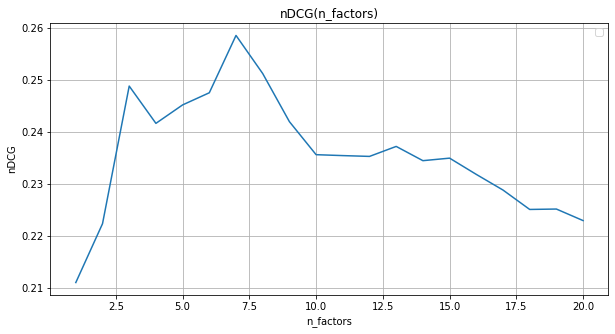

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.xlabel('n_factors')
plt.ylabel('nDCG')
plt.title('nDCG(n_factors)')
plt.grid(True)

x = np.arange(1, 21)
y = []
for i in x:
    svd = SVD(n_factors=i)
    svd.fit(train_data_csr)
    preds = svd.recommend(train_data_csr, k=10)
    y.append(nDCG(test_data_csr, preds, k=10))
plt.plot(x, y)

plt.legend()

### *Hyperparameter for UserBased and ItemBased*

In [39]:
x = np.arange(0, 1001, 100)
y = []
for min_n_rating in x:
    user_based = UserBased(min_n_rating)
    user_based.fit(train_data_csr)
    recs = user_based.recommend(train_data_csr, k=10)
    y.append(nDCG(test_data_csr, recs, k=10))

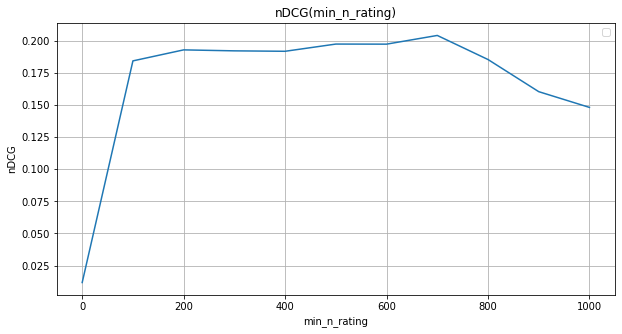

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.xlabel('min_n_rating')
plt.ylabel('nDCG')
plt.title('nDCG(min_n_rating)')
plt.grid(True)
plt.plot(x, y)
plt.legend()

### *Activation function for Autoencoder*

In [41]:
act_fns = [nn.Sigmoid, nn.Tanh, nn.Softmax, nn.ReLU]
score = []
k = 100
for act_fn in act_fns:
    autoenc = TrainAutoencoder(activation_fn=act_fn)
    autoenc.fit(train_data_csr)
    rec = autoenc.recommend(train_data_csr, k)
    score.append(nDCG(test_data_csr, rec, k))
print(pd.DataFrame(data=score, columns=['nDCG'], index=['Sigmoid', 'Tanh', 'Softmax', 'ReLU']))

             nDCG
Sigmoid  0.473520
Tanh     0.473508
Softmax  0.358701
ReLU     0.474481


### *Loss Function for Autoencoder*

In [42]:
score = []
k = 100

autoenc = TrainAutoencoder(loss_fn=BCE, act_fn_last_layer=nn.Sigmoid)
autoenc.fit(train_data_csr)
rec = autoenc.recommend(train_data_csr, k)
score.append(nDCG(test_data_csr, rec, k))

autoenc = TrainAutoencoder(loss_fn=MSE, act_fn_last_layer=nn.Sigmoid)
autoenc.fit(train_data_csr)
rec = autoenc.recommend(train_data_csr, k)
score.append(nDCG(test_data_csr, rec, k))

autoenc = TrainAutoencoder(loss_fn=MSE_masked, act_fn_last_layer=nn.Sigmoid)
autoenc.fit(train_data_csr)
rec = autoenc.recommend(train_data_csr, k)
score.append(nDCG(test_data_csr, rec, k))

print(pd.DataFrame(data=score, columns=['nDCG'], index=['BCE', 'MSE', 'MSE_masked']))

                nDCG
BCE         0.424927
MSE         0.475180
MSE_masked  0.481355


### *Activation function for last layer*

In [43]:
act_fns = [nn.Sigmoid, nn.Tanh, nn.Softmax, nn.ReLU, None]
score = []
k = 100
for act_fn in act_fns:
    autoenc = TrainAutoencoder(act_fn_last_layer=act_fn, loss_fn=MSE_masked)
    autoenc.fit(train_data_csr)
    rec = autoenc.recommend(train_data_csr, k)
    score.append(nDCG(test_data_csr, rec, k))
print(pd.DataFrame(data=score, columns=['nDCG'], index=['Sigmoid', 'Tanh', 'Softmax', 'ReLU', 'None']))

             nDCG
Sigmoid  0.480289
Tanh     0.449167
Softmax  0.426787
ReLU     0.324482
None     0.397011
